<a href="https://www.kaggle.com/code/binfeng2021/computer-vision-yolov8-on-traffic-detection?scriptVersionId=196384412" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Project Overview

In today's digitally driven world, computer vision stands as a cornerstone of technological innovation, offering machines the ability to perceive and interpret visual information much like the human eye. From autonomous vehicles navigating bustling city streets to facial recognition systems securing our smartphones, the applications of computer vision are ubiquitous and far-reaching.

Among the myriad algorithms powering computer vision systems, one standout is YOLO—You Only Look Once. YOLO represents a paradigm shift in object detection, offering unparalleled speed and accuracy by simultaneously predicting bounding boxes and class probabilities for multiple objects within a single pass through the neural network. In simple terms, YOLO enables machines to swiftly identify and categorize objects in images or video streams with remarkable efficiency.

Now, imagine leveraging the capabilities of YOLO to tackle a pressing real-world challenge: traffic sign detection. In a world where road safety is paramount, accurately identifying and interpreting traffic signs is crucial for ensuring smooth traffic flow and preventing accidents. This is where our project comes into play.

### Main Objectives

* Check the datasets
* Understand Model YOLOv8
* Train the YOLOv8 model and analyze the results
* Test the final model

### Import all necessary libraries

In [10]:
!pip install ultralytics

In [11]:
# import all necessary libraries
import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO

In [12]:
# trun off wandb reporting for this notebook
os.environ['WANDB_DISABLED'] = 'true'

## Explore the datasets

### Check the training images

In [13]:
train_img_dir = '/kaggle/input/cardetection/car/train/images'

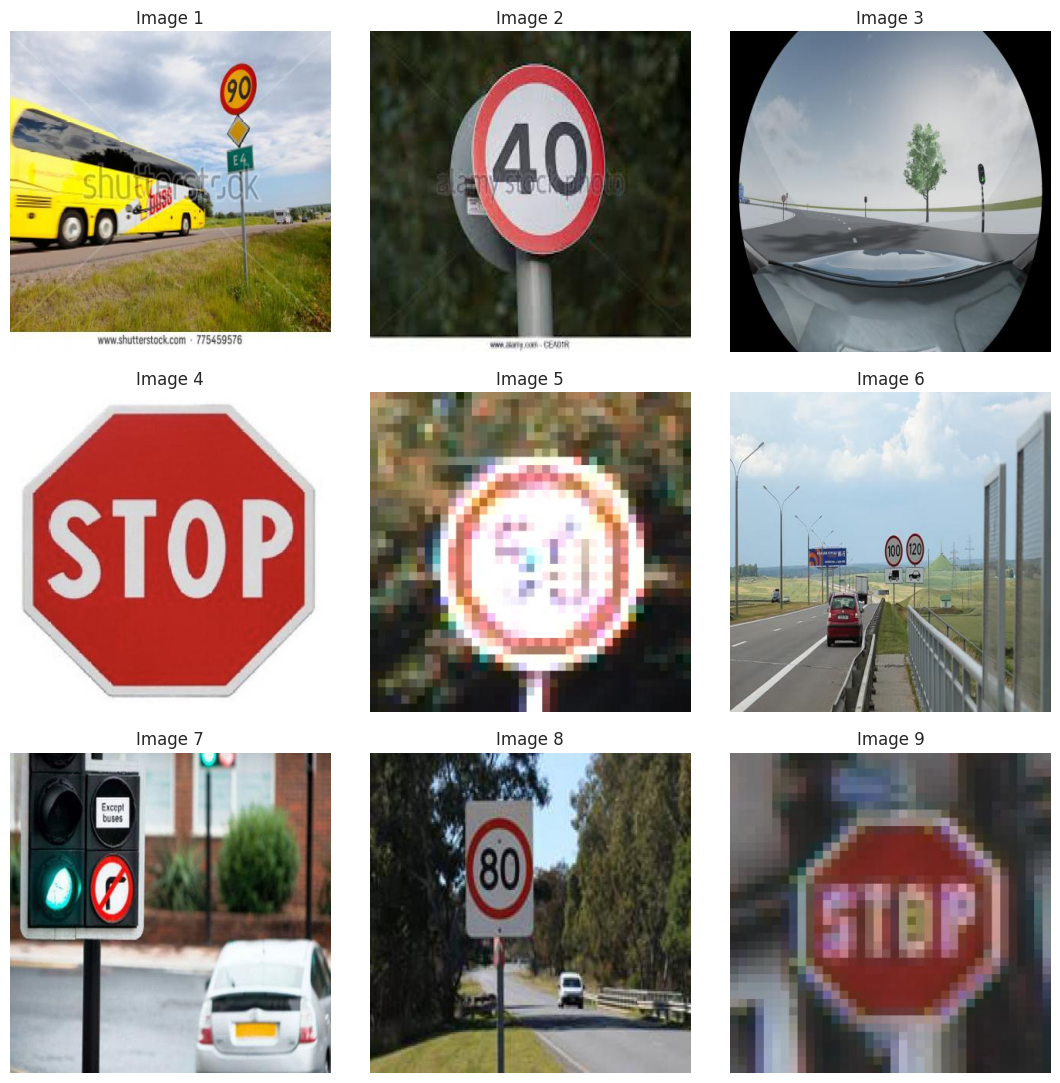

In [14]:
num_samples = 9
image_files = os.listdir(train_img_dir)
rand_imgs = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = rand_imgs[i]
    ax = axes[i // 3, i%3]
    ax.imshow(plt.imread(os.path.join(train_img_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

According to the **data.yaml** file, we have 15 different labeled classes in the dataset, shown as below:

['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

## Understand Model YOLOv8

YOLO, which stands for "You Only Look Once," is a groundbreaking object detection algorithm in computer vision. Unlike traditional object detection algorithms that involve multiple stages of processing, YOLO processes the entire image in a single pass through a convolutional neural network (CNN). This approach allows YOLO to achieve real-time object detection with impressive speed and accuracy.

### Technical Details

1. The algorithm will take the input image and split it into a grid of cells. Each cell will predict bounding boxes and a confidence score for each box. The bounding boxes indicates the location of detected object in the images and the confidence value indicates the model's certainty of the prediction. 

2. Other than confidence socre for each bounding boxes, YOLO also predicts an "objectness" score for each box that indicate the likelihood that the box contains a meaningful object, not just background clutter.

3. Last but not the least, YOLO also predicts the class for each bounding box detected. The probability generated measures the likelihood of the detected obeject belonging to different predefined classes. 

4. To generate final output, YOLO will combine a set of bounding boxes from previous steps, each bounding box is associated with its class label and confidence socre. Those combined bounding boxes then can represent the objects detected along with its location in the image and classified label. To prevent redundant and improve localization accuracy, YOLO applied a technic called Non-Maximum Suppression (NMS) to those predicted bounding boxes. NMS selects the most confident bounding boxes while suppressing overlapping detections with lower confidence scores. 



### Check out the pre-trained YOLOv8 Model

In [15]:
model = YOLO("yolov8n.pt")


image 1/1 /kaggle/input/cardetection/car/train/images/000844_jpg.rf.6fab11a473d29cecbb8affb9b3bc70bb.jpg: 416x416 1 bus, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/train/images/000243_jpg.rf.8ef08ce07a0885b98caee0372d61bca0.jpg: 416x416 1 stop sign, 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/train/images/FisheyeCamera_1_00311_png.rf.b0abeeb32df8e582d0584c01e8a3e5d8.jpg: 416x416 (no detections), 7.0ms
Speed: 0.7ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/train/images/road80_png.rf.bc2551fd16d8c56a6978f0642e28b7bd.jpg: 416x416 1 stop sign, 7.8ms
Speed: 1.1ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/train/images/00002_0000

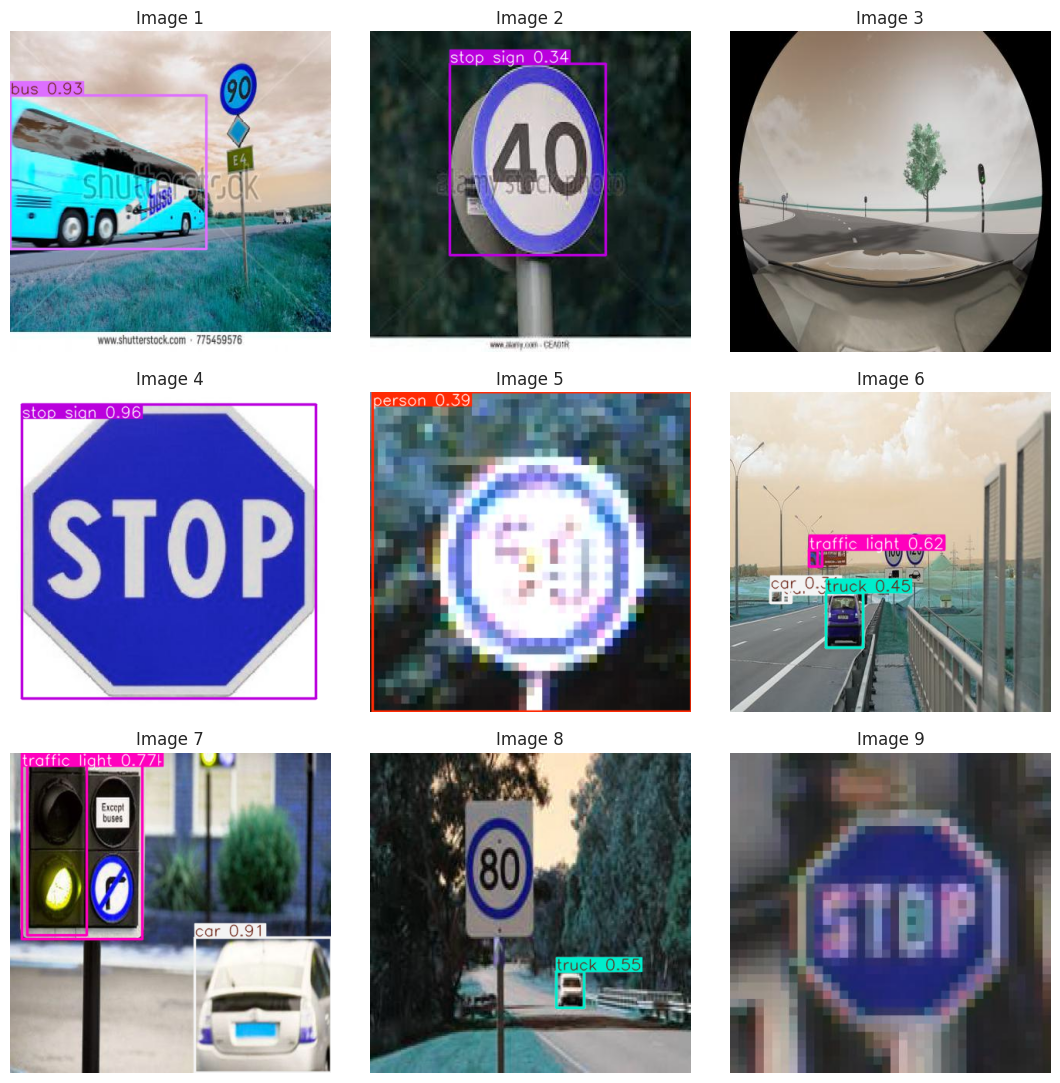

In [16]:
fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = rand_imgs[i]
    ax = axes[i // 3, i%3]
    result_predict = model.predict(source = os.path.join(train_img_dir, image), imgsz = (416))
    ax.imshow(result_predict[0].plot())
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

The pre-trained YOLO does not perform very well, most of the traffic signs were not detected, or correctly labled. We will fine-tune the model using the specified dataset and see how the performance might change. 

## Fine-tune YOLOv8 with given training dataset

In [17]:
final_model = YOLO('yolov8n.yaml').load('yolov8m.pt')

Transferred 94/355 items from pretrained weights


In [18]:
Result_Final_model = final_model.train(data="/kaggle/input/cardetection/car/data.yaml",epochs=50, imgsz = 416, device = -1)

Ultralytics YOLOv8.2.92 🚀 Python-3.10.13 torch-2.1.2 CUDA:-1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/kaggle/input/cardetection/car/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=-1, workers=8, project=None, name=train2, exist_ok=False, pretrained=yolov8m.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

train: Scanning /kaggle/input/cardetection/car/train/labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:03<00:00, 901.42it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/cardetection/car/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/cardetection/car/valid/labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<00:00, 905.60it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/cardetection/car/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.94G       3.11      4.814      2.902         26        416: 100%|██████████| 221/221 [00:25<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.55it/s]


                   all        801        944    0.00123      0.366    0.00312    0.00109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.89G      2.076      3.903      1.944         19        416: 100%|██████████| 221/221 [00:23<00:00,  9.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.98it/s]

                   all        801        944      0.391      0.297      0.116     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.88G      1.401      2.868      1.354         17        416: 100%|██████████| 221/221 [00:22<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.89it/s]


                   all        801        944      0.196      0.312      0.127     0.0835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.88G      1.137      2.429      1.188         12        416: 100%|██████████| 221/221 [00:22<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]


                   all        801        944       0.22      0.488      0.173      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.88G      1.025      2.218      1.128         18        416: 100%|██████████| 221/221 [00:22<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]


                   all        801        944      0.192      0.489      0.193      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.87G     0.9672      2.082      1.109         21        416: 100%|██████████| 221/221 [00:22<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]


                   all        801        944      0.214      0.502      0.229      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.87G     0.9359      1.986      1.093         21        416: 100%|██████████| 221/221 [00:22<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.15it/s]

                   all        801        944      0.254      0.496      0.267      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.87G     0.8665      1.868      1.054         15        416: 100%|██████████| 221/221 [00:22<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.84it/s]


                   all        801        944      0.242      0.521      0.278      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.88G     0.8437      1.827       1.05         21        416: 100%|██████████| 221/221 [00:22<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.36it/s]


                   all        801        944       0.23      0.537      0.308      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.87G     0.8223      1.768       1.04         25        416: 100%|██████████| 221/221 [00:22<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]


                   all        801        944      0.259      0.486      0.311      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.88G      0.812      1.732      1.032         20        416: 100%|██████████| 221/221 [00:22<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]


                   all        801        944      0.276      0.441      0.329      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.87G     0.8025      1.721      1.029         27        416: 100%|██████████| 221/221 [00:22<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.37it/s]


                   all        801        944      0.371      0.499      0.337      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.88G     0.7765      1.674      1.016         29        416: 100%|██████████| 221/221 [00:22<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.43it/s]


                   all        801        944      0.301      0.514      0.335      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.86G     0.7546      1.655      1.007         25        416: 100%|██████████| 221/221 [00:22<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]


                   all        801        944      0.337      0.476      0.364      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.88G     0.7445       1.63      1.003         21        416: 100%|██████████| 221/221 [00:22<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.36it/s]


                   all        801        944      0.314      0.488        0.4      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.87G     0.7439      1.592      1.006         23        416: 100%|██████████| 221/221 [00:22<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]


                   all        801        944       0.38      0.524      0.413      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.88G     0.7276      1.565     0.9985         25        416: 100%|██████████| 221/221 [00:22<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.16it/s]


                   all        801        944      0.375      0.479      0.431      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.86G     0.7297      1.543     0.9996         27        416: 100%|██████████| 221/221 [00:22<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.16it/s]


                   all        801        944      0.376      0.512       0.43      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.87G     0.7151      1.517     0.9907         25        416: 100%|██████████| 221/221 [00:22<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.47it/s]


                   all        801        944      0.482      0.454      0.465      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.87G        0.7      1.474     0.9876         26        416: 100%|██████████| 221/221 [00:22<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.28it/s]


                   all        801        944      0.455      0.542      0.481      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.87G     0.7033       1.47      0.985         17        416: 100%|██████████| 221/221 [00:22<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.68it/s]


                   all        801        944      0.471      0.533      0.507      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.86G     0.6866      1.448     0.9812         16        416: 100%|██████████| 221/221 [00:22<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]

                   all        801        944      0.484      0.482      0.503      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.88G     0.7018      1.436      0.986         29        416: 100%|██████████| 221/221 [00:22<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.50it/s]


                   all        801        944      0.496      0.577      0.577       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.88G      0.697      1.396      0.983         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]


                   all        801        944      0.618      0.563      0.611      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.88G     0.6787      1.347     0.9817         30        416: 100%|██████████| 221/221 [00:22<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.46it/s]

                   all        801        944      0.601      0.602       0.62      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.86G      0.682      1.319     0.9747         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.36it/s]


                   all        801        944      0.681      0.608      0.659      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.88G     0.6706      1.296     0.9743         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]


                   all        801        944      0.595      0.594      0.624      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.87G     0.6757      1.271     0.9724         26        416: 100%|██████████| 221/221 [00:22<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.24it/s]


                   all        801        944      0.681      0.623      0.669      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.87G     0.6665      1.258     0.9729         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.31it/s]


                   all        801        944      0.637      0.658      0.675       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.86G     0.6511       1.19     0.9613         25        416: 100%|██████████| 221/221 [00:22<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.54it/s]

                   all        801        944      0.666       0.64      0.685      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.88G     0.6653      1.206     0.9632         28        416: 100%|██████████| 221/221 [00:22<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.38it/s]


                   all        801        944       0.73      0.611       0.69      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.88G      0.652      1.162     0.9655         26        416: 100%|██████████| 221/221 [00:22<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.19it/s]

                   all        801        944      0.714      0.669      0.716      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.87G     0.6477      1.161     0.9649         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.38it/s]

                   all        801        944      0.753      0.651      0.726      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.86G     0.6361      1.128     0.9591         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  6.75it/s]


                   all        801        944       0.74      0.646      0.715      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.87G     0.6347      1.096     0.9598         17        416: 100%|██████████| 221/221 [00:22<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.39it/s]


                   all        801        944      0.762      0.636      0.735      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.87G     0.6387      1.101     0.9603         17        416: 100%|██████████| 221/221 [00:22<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.42it/s]


                   all        801        944      0.735      0.672      0.742      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.87G     0.6391      1.065     0.9635         19        416: 100%|██████████| 221/221 [00:22<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.20it/s]


                   all        801        944      0.778      0.693      0.753      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.86G     0.6296       1.05     0.9547         24        416: 100%|██████████| 221/221 [00:22<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.38it/s]


                   all        801        944      0.809      0.653      0.754       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.87G     0.6209      1.052     0.9574         22        416: 100%|██████████| 221/221 [00:22<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]


                   all        801        944      0.823      0.692      0.785      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.87G     0.6306      1.051      0.957         17        416: 100%|██████████| 221/221 [00:22<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.23it/s]

                   all        801        944      0.811      0.688       0.77      0.658


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.87G     0.6124     0.8446       0.92         12        416: 100%|██████████| 221/221 [00:23<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]

                   all        801        944      0.862      0.675      0.782      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.86G     0.6017     0.7987     0.9117         13        416: 100%|██████████| 221/221 [00:21<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.18it/s]


                   all        801        944      0.832      0.713      0.796      0.684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.87G     0.5941     0.7718     0.9065         11        416: 100%|██████████| 221/221 [00:22<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.36it/s]

                   all        801        944      0.811      0.723      0.796      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.87G     0.5862     0.7472     0.9014         10        416: 100%|██████████| 221/221 [00:22<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.35it/s]


                   all        801        944        0.9       0.69      0.809      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.87G     0.5772     0.7254     0.9045         12        416: 100%|██████████| 221/221 [00:22<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.47it/s]

                   all        801        944       0.86      0.718      0.817      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.86G     0.5697     0.7061     0.8967         10        416: 100%|██████████| 221/221 [00:21<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.26it/s]


                   all        801        944      0.882      0.707      0.816      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.87G     0.5747     0.7033      0.905         13        416: 100%|██████████| 221/221 [00:21<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.29it/s]


                   all        801        944      0.877      0.727      0.821      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.87G     0.5681     0.6859     0.8972         14        416: 100%|██████████| 221/221 [00:21<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.27it/s]

                   all        801        944      0.926      0.702      0.824      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.87G     0.5651     0.6776     0.8949         14        416: 100%|██████████| 221/221 [00:22<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.22it/s]


                   all        801        944      0.895      0.718      0.828      0.719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.86G     0.5551     0.6705     0.8925         14        416: 100%|██████████| 221/221 [00:22<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:03<00:00,  7.25it/s]


                   all        801        944      0.899      0.722      0.828      0.721

50 epochs completed in 0.380 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.13 torch-2.1.2 CUDA:-1 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 168 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.67it/s]


                   all        801        944      0.899      0.721      0.828      0.721
           Green Light         87        122      0.784      0.492      0.584      0.308
             Red Light         74        108      0.886      0.434       0.56      0.304
       Speed Limit 100         52         52      0.847      0.885      0.937      0.837
       Speed Limit 110         17         17      0.882      0.529       0.72      0.687
       Speed Limit 120         60         60      0.956      0.833      0.915      0.843
        Speed Limit 20         56         56      0.984      0.893      0.967      0.845
        Speed Limit 30         71         74       0.93       0.77      0.908      0.851
        Speed Limit 40         53         55      0.922      0.836        0.9       0.79
        Speed Limit 50         68         71      0.906       0.68      0.845      0.767
        Speed Limit 60         76         76       0.96      0.776      0.871      0.802
        Speed Limit 7

## Analyze the final model's performance

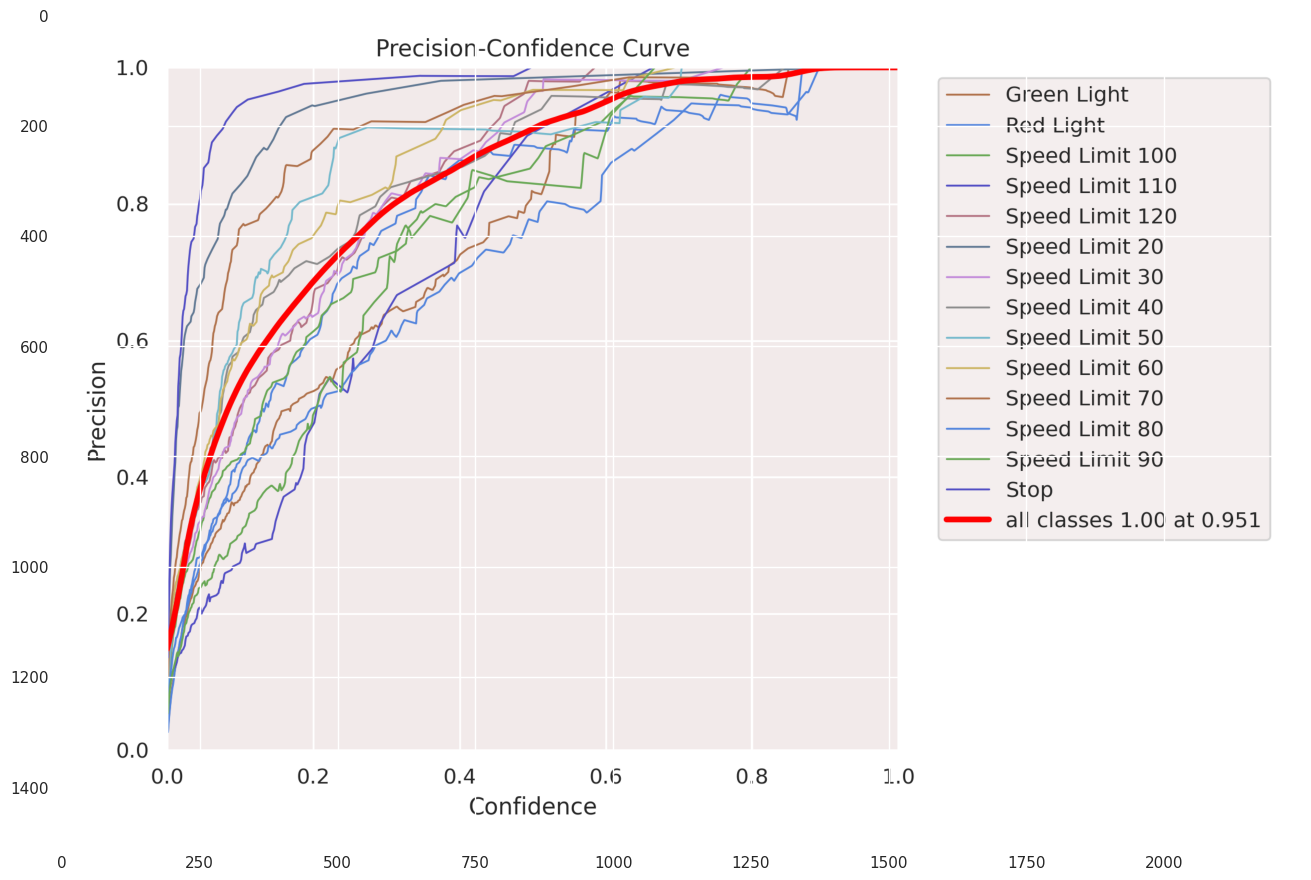

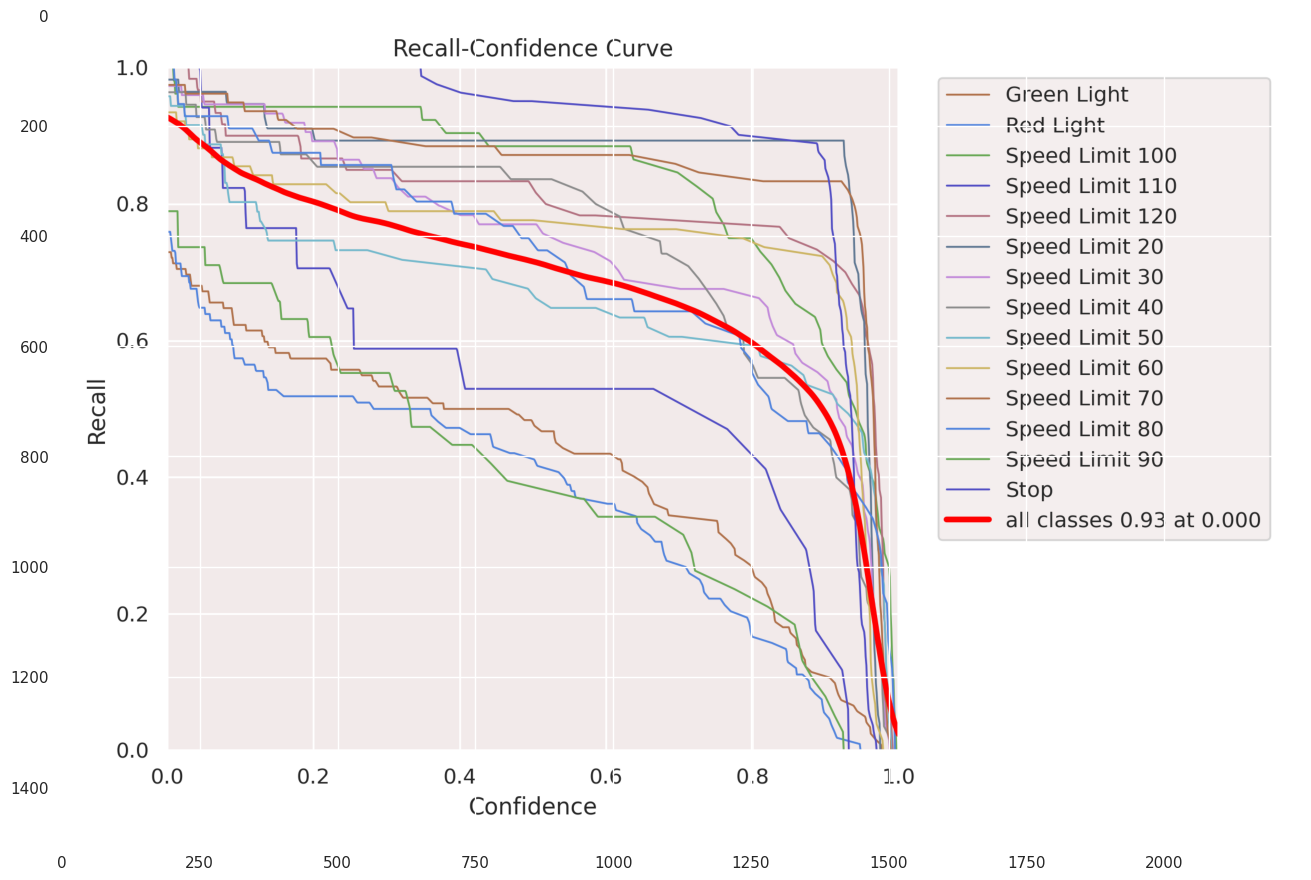

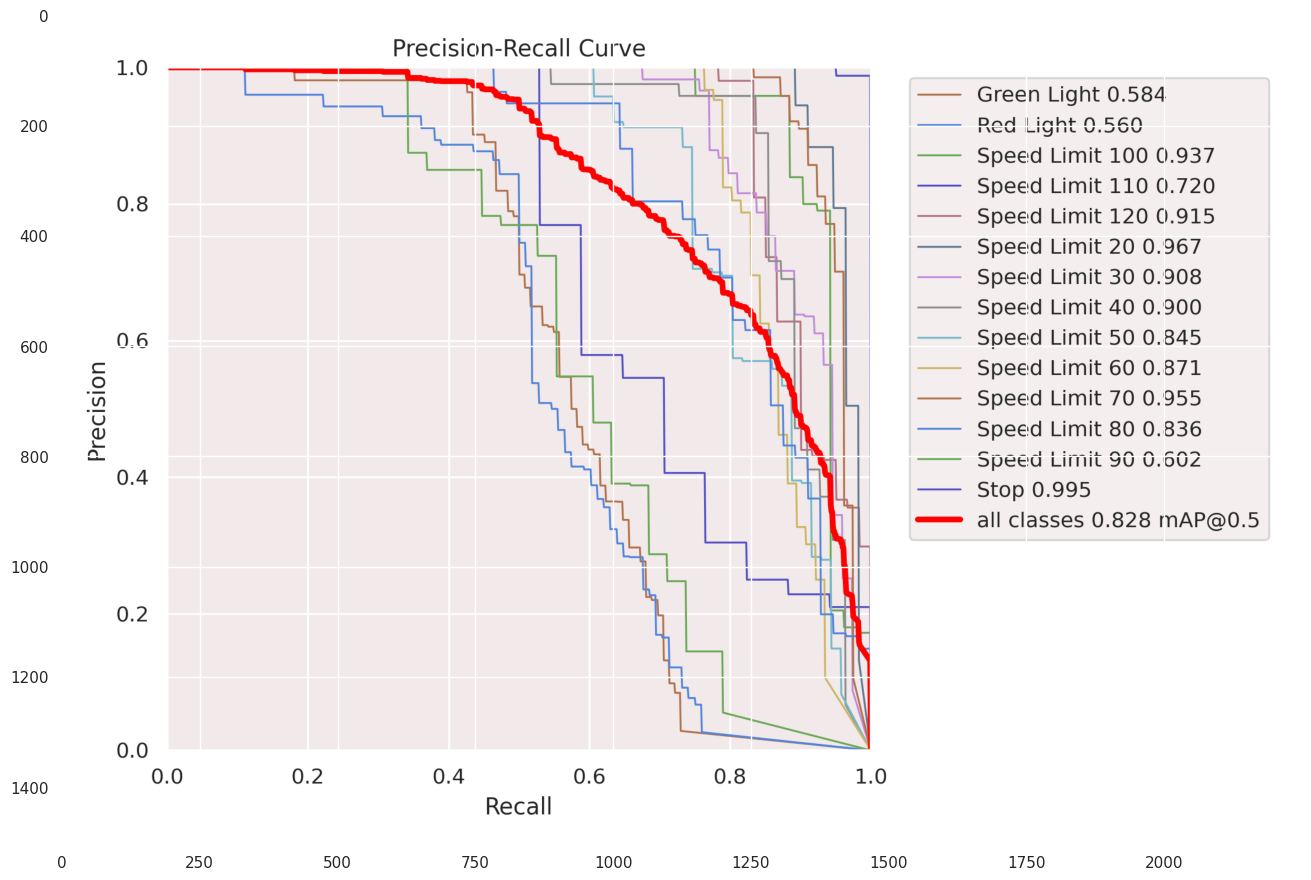

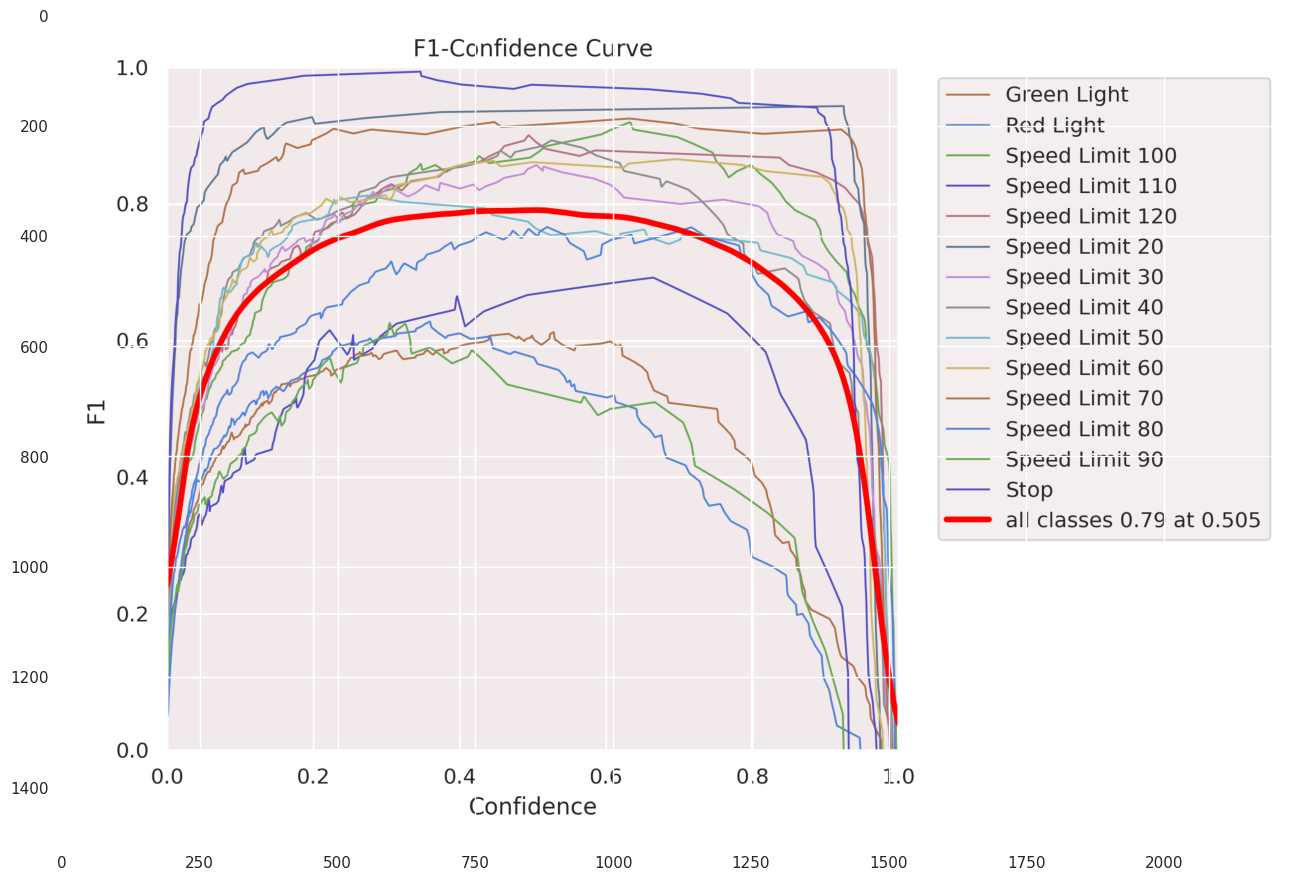

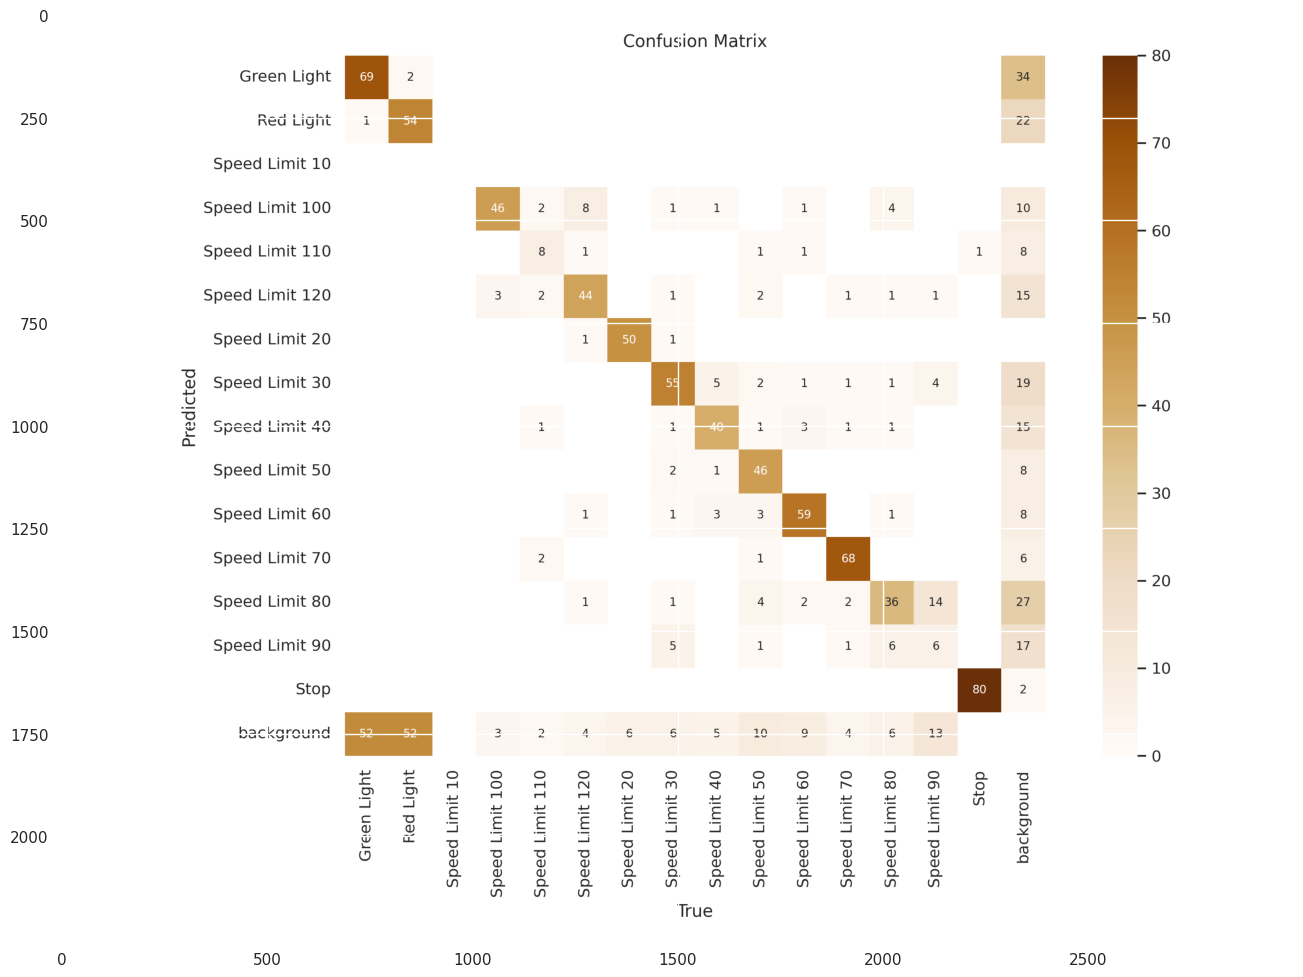

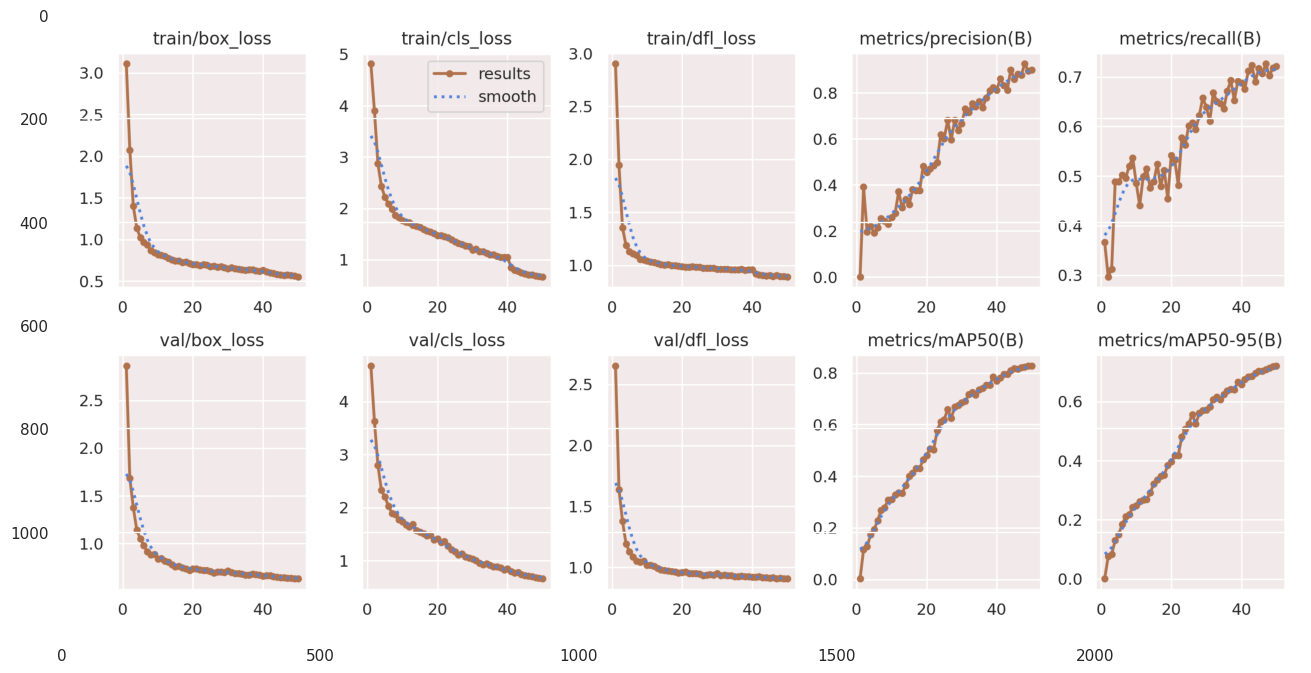

In [26]:
list_of_metrics = ["P_curve.png", "R_curve.png", "PR_curve.png", "F1_curve.png","confusion_matrix.png", "results.png"]
for i in list_of_metrics:
    
    image = cv2.imread(f'/kaggle/working/runs/detect/train2/{i}')
    plt.figure(figsize=(16, 12))
    plt.imshow(image)
    plt.show()

#### Interpretation of the plots

1. **Precision-confidence Curve**: a graphical representation of how precision of the model changes at different confidence levels. In the first plot, we can see that the precisions of the model increases for all classes as the confidence increases. We are able to reach to precision score 1 for all classes when the confidence threshold is 0.958.

2. **Recall-confidence Curve**: a graphical representation of how recall of the model changes at different confidence levels. In the second plot, we can see that the recall of the model decreases for all classes as the confidence increases. The recall for all classes is 0.94 when the confidence threshold is 0.

3. **Precision-Recall Curve**: a graphical representation of the trade-off between precision and recall for different threshold used. From the third plot, we see that the model's precision decreases as the recall increases. When using IoU threshold (intersection over Union) of 0.5, the model is able to achieve mAP (mean average precision) of 0.908.

4. **F1-Confidence Curve**: a graphic representation of how F1 score of the model changes at different confidence levels. Since F1 score is caluclated using both precision and recall scores, it can be a good visualization of how the model is preforming overall. From the fourth plot, we can see that the F1 score increases and then decreases as the confidence threshold increases. When setting the confidence threshold as 0.319, we are able to achieve a F1 score of 0.88 for all classes. 

5. **Confusion Matrix**: a table that allows visualization of the performance of a classificaiotn model by summarizing the correct and incorrect classifications. The diagonal of the table shows all ture positives made by the model. As we can see from the fifth plot, most of high value numbers in the table are in the diagonal line, so we can conclude that the model is able to make correct prediction in most cases. 

6. **Results plot during training**: a combanation of different metrics measured during training process. In the sixth plot, we can see multiple visualization of different metrics values changes over different epochs. To better understand the results, we need to understand the different loss values measured first. 

box_loss: is also known as localication loss or regression loss. It measures the discrepancy between the predicted bounding box coordinates and the ground truth bounding box coordinates for each object in the image.

cls_loss: is konwn as classification loss. It measures the accuracy of the predicted class labels assigned to each bounding box.

dfl_loss: is known as domain-fused loss. It measures the discrepancy between feature representations learned by the model across different domains. The goal of minimizing dfl loss is to better align the feature representations across different domains, so that the model is able to improve the preformance in real-world scenarios where the testing data may differ from the training data. 

From the plots included in the sixth figure, we can see that all of those three loss values decreases and the precision and recall scores are increasing as more epoches trained. 

## Test the model on test data


image 1/1 /kaggle/input/cardetection/car/test/images/2257b962-595c-43ae-8f0d-575f1b55beb8_jpg.rf.d8ba84a72e00584f12f54d3cf03c8dc0.jpg: 416x416 1 Green Light, 7.0ms
Speed: 0.9ms preprocess, 7.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/test/images/000983_JPG_jpg.rf.435a52389bec50fc37b8d83dc287f3ed.jpg: 416x416 2 Green Lights, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/test/images/00000_00005_00003_png.rf.df858754a637fecb106924e9bc47a832.jpg: 416x416 1 Speed Limit 20, 7.3ms
Speed: 0.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input/cardetection/car/test/images/000596_jpg.rf.eb635457db0d42d1d585000296f83145.jpg: 416x416 1 Speed Limit 80, 7.3ms
Speed: 0.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /kaggle/input

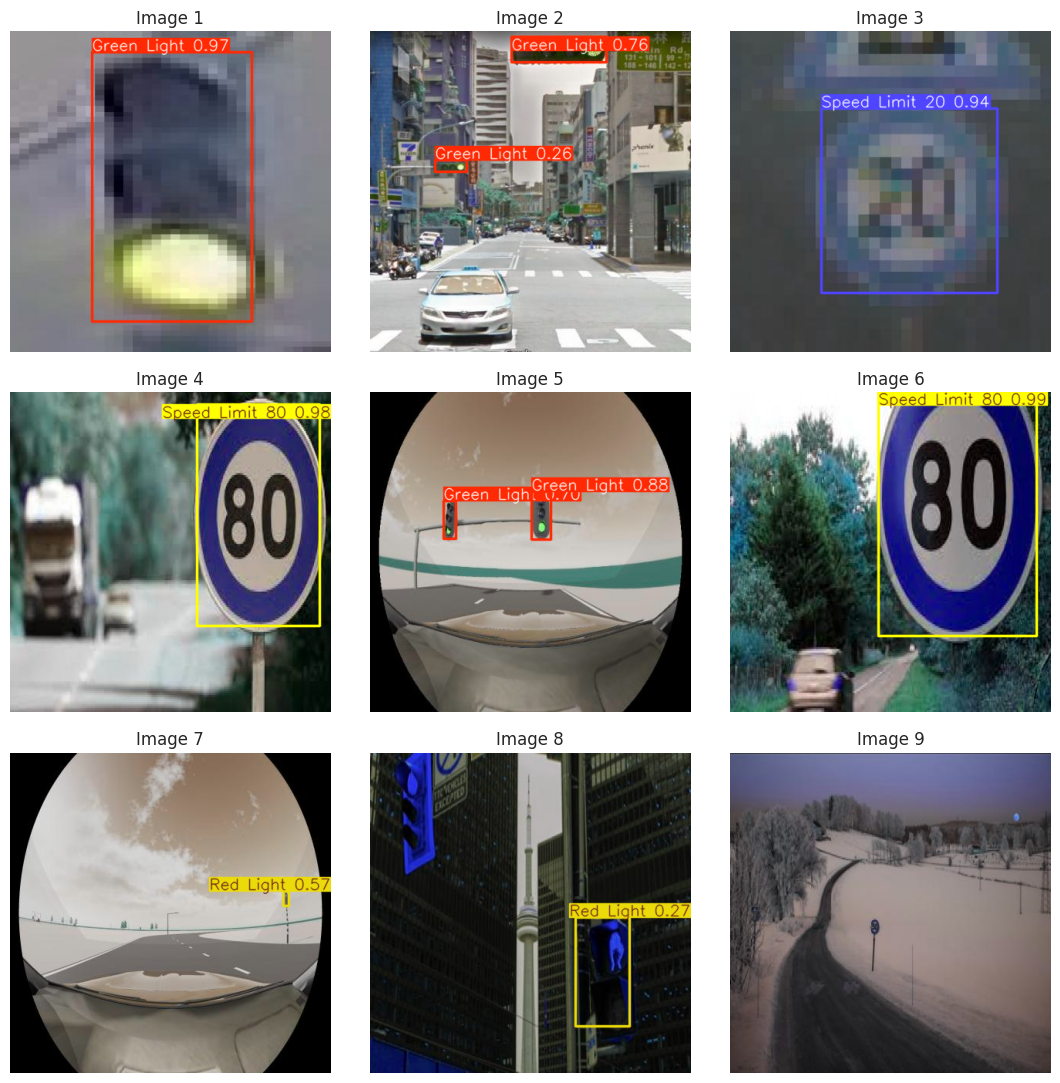

In [24]:
test_img_dir = '/kaggle/input/cardetection/car/test/images'
num_samples = 9
image_files = os.listdir(test_img_dir)
test_imgs = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3,3, figsize = (11, 11))
for i in range(num_samples):
    image = test_imgs[i]
    ax = axes[i // 3, i%3]
    result_predict = final_model.predict(source = os.path.join(test_img_dir, image), imgsz = (416))
    ax.imshow(result_predict[0].plot())
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

Based on the results obtained from the test images, we can see a significant performance increase from the pre-trained model. YOLOv8 has performed very well after training and can detect most objects that we specified in the dataset. 

## Conclusion

In this project, we utilized the YOLO model for traffic detection, starting with familiarization and testing of a pre-trained model. Then, we have fine-tuned the model with our dataset. The retrained model shows a significantly improved performance. We have also analyzed different metrics and plots obtained during the training process. All of those plots shows the confirmation of enhanced accuracy. 

### Current Limitation & Future work

- To improve the performance further, we could involve further optimization by adjusting parameters used in the YOLO model, for this project, I have only used default parameters mostly, but we can try out different parameter combinations to find the optional model to use. 

- During the analysis of the training results, we noticed that the model performance continue to increase in different metrics as number of epoches increase. So we can continue to train the model with more epoches, this should result in performance increase as well.

- Last but not least, the provided dataset only contains ~3.5K training images. If we can expand the training dataset further by including more samples, we could obtain a even better results. 


### Thank you!

If you found this notebook interesting, please give me a upvote! If you have any thoughts, I would love to hear it in the comments section! Thank you for reading!